In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers


In [2]:
# Hyperparameters (centralized)
THRESHOLD = 0.04
IMG_SIZE = (224, 224)
IMG_CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-4
DROPOUT = 0.2
EARLY_STOPPING_PATIENCE = 3
AUGMENTATION = True

# EfficientNet settings
TRAIN_BACKBONE = False
FINE_TUNE = True
UNFREEZE_LAST_N = 20
FINE_TUNE_EPOCHS = 5
FINE_TUNE_LR = 1e-5

# Ensure channels_last for pretrained weights
tf.keras.backend.set_image_data_format("channels_last")


In [3]:
# Load labeled data (void rate regression)
import re

csv_path = Path("CrackVoid Ratios") / "Xray Void Ratio.csv"
df = pd.read_csv(csv_path, sep=";")
df["Void rate"] = pd.to_numeric(df["Void rate"], errors="coerce")
df = df.dropna(subset=["Void rate"])

def key_from_row(r):
    return (r["Led Type"], int(r["Panel"]), int(r["LED Number"]))

lookup = {key_from_row(r): r for _, r in df.iterrows()}

xray_root = Path("XRay") / "XRay"
rows = []

for img_path in xray_root.rglob("*.jpg"):
    name = img_path.name
    parts = name.split("_")
    if len(parts) < 5:
        continue
    led_type = parts[1]
    panel = None
    led_num = None
    for part in parts:
        if part.startswith("Panel"):
            panel = int(re.sub(r"[^\d]", "", part))
        if part.startswith("LED"):
            led_num = int(re.sub(r"[^\d]", "", part))
    if panel is None or led_num is None:
        continue
    key = (led_type, panel, led_num)
    if key in lookup:
        r = lookup[key]
        rows.append({
            "path": str(img_path),
            "void_rate": float(r["Void rate"]),
            "panel": panel,
        })

labeled = pd.DataFrame(rows)
labeled.head()


,path,void_rate,panel
0,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0.031611,1
1,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0.018718,1
2,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0.005978,1
3,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0.015036,1
4,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0.023375,1


In [4]:
labeled["void_rate"].describe()


count    1800.000000
mean        0.028636
std         0.023569
min         0.000000
25%         0.010268
50%         0.023420
75%         0.039848
max         0.107209
Name: void_rate, dtype: float64

In [5]:
# Train/val/test split with panel-level split to reduce leakage
from sklearn.model_selection import train_test_split

panels = labeled["panel"].unique()
train_panels, temp_panels = train_test_split(panels, test_size=0.3, random_state=42)
val_panels, test_panels = train_test_split(temp_panels, test_size=0.5, random_state=42)

train_df = labeled[labeled["panel"].isin(train_panels)].reset_index(drop=True)
val_df = labeled[labeled["panel"].isin(val_panels)].reset_index(drop=True)
test_df = labeled[labeled["panel"].isin(test_panels)].reset_index(drop=True)

train_df.shape, val_df.shape, test_df.shape

# Target normalization (z-score) for regression
y_mean = train_df["void_rate"].mean()
y_std = train_df["void_rate"].std() + 1e-8

def normalize_y(y):
    return (y - y_mean) / y_std

def denormalize_y(y):
    return (y * y_std) + y_mean



In [6]:
# Ambiguity weighting around the label threshold
MIDDLE_BAND = 0.01   # +/- range around THRESHOLD treated as ambiguous
MIN_WEIGHT = 0.5     # how much to down-weight ambiguous samples
SEED = 42

def compute_weights(void_rates: np.ndarray) -> np.ndarray:
    dist = np.abs(void_rates - THRESHOLD)
    w = MIN_WEIGHT + (1.0 - MIN_WEIGHT) * np.clip(dist / MIDDLE_BAND, 0.0, 1.0)
    return w.astype(np.float32)


def load_image(path, label, weight):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)
    return img, label, weight


def make_ds(df, shuffle=True):
    paths = df["path"].values
    labels = normalize_y(df["void_rate"].values.astype(np.float32))
    weights = compute_weights(df["void_rate"].values.astype(np.float32))

    ds = tf.data.Dataset.from_tensor_slices((paths, labels, weights))
    if shuffle:
        ds = ds.shuffle(min(len(df), 2000), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = make_ds(train_df, shuffle=True)
val_ds = make_ds(val_df, shuffle=False)
test_ds = make_ds(test_df, shuffle=False)



In [7]:
# EfficientNetV2B0 regression model (pretrained)

tf.keras.backend.clear_session()
tf.keras.backend.set_image_data_format("channels_last")
IMG_CHANNELS = 3  # force RGB at runtime
print("IMG_CHANNELS:", IMG_CHANNELS, "data_format:", tf.keras.backend.image_data_format())
assert IMG_CHANNELS == 3, "EfficientNetV2 ImageNet weights require 3 channels"

# Simple augmentation (can be toggled)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="data_augmentation")

inputs = layers.Input(shape=(224, 224, IMG_CHANNELS))
x = data_augmentation(inputs) if AUGMENTATION else inputs
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)

base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
)
base_model.trainable = TRAIN_BACKBONE

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(DROPOUT)(x)
outputs = layers.Dense(1, activation="linear")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="mse",
    metrics=["mae"],
)
model.summary()



IMG_CHANNELS: 3 data_format: channels_last


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

# Fine-tune top layers (optional)
if FINE_TUNE:
    base_model.trainable = True
    if UNFREEZE_LAST_N > 0:
        for layer in base_model.layers[:-UNFREEZE_LAST_N]:
            layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
        loss="mse",
        metrics=["mae"],
    )

    fine_tune_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=EARLY_STOPPING_PATIENCE,
            restore_best_weights=True,
        )
    ]

    fine_tune_history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=FINE_TUNE_EPOCHS,
        callbacks=fine_tune_callbacks,
    )

    for k, v in fine_tune_history.history.items():
        history.history[k] += v

model.evaluate(test_ds)


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 51s 652ms/step - loss: 1.2026 - mae: 0.8148 - val_loss: 0.7663 - val_mae: 0.7587
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 578ms/step - loss: 0.9676 - mae: 0.7344 - val_loss: 0.7643 - val_mae: 0.7614
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 572ms/step - loss: 0.8106 - mae: 0.6842 - val_loss: 0.7135 - val_mae: 0.7338
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 570ms/step - loss: 0.7416 - mae: 0.6605 - val_loss: 0.6908 - val_mae: 0.7207
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 569ms/step - loss: 0.7088 - mae: 0.6594 - val_loss: 0.6863 - val_mae: 0.7185
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 582ms/step - loss: 0.6268 - mae: 0.6172 - val_loss: 0.6775 - val_mae: 0.7125
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 571ms/step - loss: 0.5579 - mae: 0.5864 - val_loss: 0.6533 - val_mae: 0.6974
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 579ms/step - loss: 0.5646 - mae: 0.5767 - val_loss: 0.6244 - val_mae: 0.6769
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 586ms/

[0.45201200246810913, 0.5839089155197144]

29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 477ms/step
MAE: 0.01432  MSE: 0.00029  R2: 0.5416


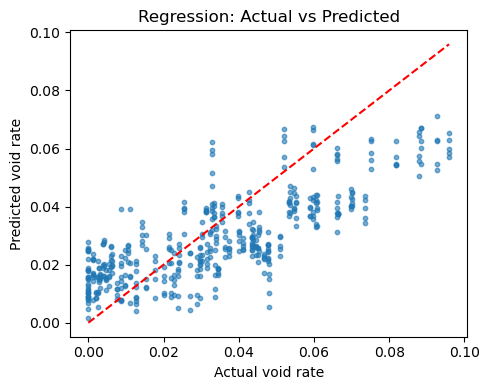

In [9]:
# Regression metrics + plots
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

y_true = np.concatenate([y.numpy() for _, y, _ in test_ds], axis=0)
y_true = denormalize_y(y_true)

test_ds_pred = test_ds.map(lambda x, y, w: x)
y_pred = model.predict(test_ds_pred).ravel()
y_pred = denormalize_y(y_pred)


mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"MAE: {mae:.5f}  MSE: {mse:.5f}  R2: {r2:.4f}")

plt.figure(figsize=(5, 4))
plt.scatter(y_true, y_pred, s=10, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual void rate")
plt.ylabel("Predicted void rate")
plt.title("Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Ground truth class from label threshold
y_true_cls = (y_true >= THRESHOLD).astype(int)

# Sweep decision thresholds
thresholds = np.linspace(y_pred.min(), y_pred.max(), 200)

results = []
for thr in thresholds:
    y_pred_cls = (y_pred >= thr).astype(int)
    prec = precision_score(y_true_cls, y_pred_cls, zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, zero_division=0)
    results.append((thr, prec, rec, f1))

# Filter by recall constraint
target_recall = 0.95
candidates = [r for r in results if r[2] >= target_recall]

if candidates:
    best = max(candidates, key=lambda x: x[1])  # maximize precision
    print(f"Best threshold @ recall≥{target_recall}: thr={best[0]:.4f} "
          f"P={best[1]:.3f} R={best[2]:.3f} F1={best[3]:.3f}")
else:
    print("No threshold meets the target recall")

# Optional: also show best F1 overall
best_f1 = max(results, key=lambda x: x[3])
print(f"Best F1: thr={best_f1[0]:.4f}  P={best_f1[1]:.3f}  R={best_f1[2]:.3f}  F1={best_f1[3]:.3f}")


Best threshold @ recall≥0.95: thr=0.0218 P=0.604 R=0.950 F1=0.739
Best F1: thr=0.0246  P=0.641  R=0.894  F1=0.747


Best F1: thr=0.0254  P=0.655  R=0.856  F1=0.742
Best Recall: thr=0.0000  P=0.400  R=1.000  F1=0.571
Best threshold @ recall≥0.95: thr=0.0215 P=0.597 R=0.956 F1=0.735
              precision    recall  f1-score   support

           0     0.9506    0.5704    0.7130       270
           1     0.5972    0.9556    0.7350       180

    accuracy                         0.7244       450
   macro avg     0.7739    0.7630    0.7240       450
weighted avg     0.8093    0.7244    0.7218       450



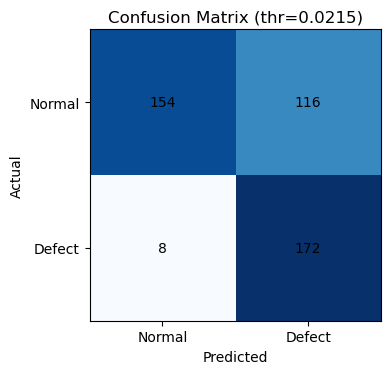

In [10]:
# Threshold sweep (regression -> classification)
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Ground truth based on label threshold
y_true_cls = (y_true >= THRESHOLD).astype(int)

# Sweep possible decision thresholds on predictions
thresholds = np.linspace(0.0, y_true.max(), 50)

results = []
for thr in thresholds:
    y_pred_cls = (y_pred >= thr).astype(int)
    prec = precision_score(y_true_cls, y_pred_cls, zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, zero_division=0)
    results.append((thr, prec, rec, f1))

# Best F1 and best recall
best_f1 = max(results, key=lambda x: x[3])
best_recall = max(results, key=lambda x: x[2])

print(f"Best F1: thr={best_f1[0]:.4f}  P={best_f1[1]:.3f}  R={best_f1[2]:.3f}  F1={best_f1[3]:.3f}")
print(f"Best Recall: thr={best_recall[0]:.4f}  P={best_recall[1]:.3f}  R={best_recall[2]:.3f}  F1={best_recall[3]:.3f}")

# Pick threshold with recall >= 0.95 and best precision
target_recall = 0.95
candidates = [r for r in results if r[2] >= target_recall]  # (thr, prec, rec, f1)
best = max(candidates, key=lambda x: x[1])  # maximize precision
print(f"Best threshold @ recall≥{target_recall}: thr={best[0]:.4f} P={best[1]:.3f} R={best[2]:.3f} F1={best[3]:.3f}")

# Use this threshold for confusion matrix
thr = best[0]
y_pred_cls = (y_pred >= thr).astype(int)

# Confusion matrix at best recall (for packaging QC)
# Use this threshold for confusion matrix (recall>=0.95 best precision)
thr = best[0]
y_pred_cls = (y_pred >= thr).astype(int)

cm = confusion_matrix(y_true_cls, y_pred_cls)
print(classification_report(y_true_cls, y_pred_cls, digits=4))

plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")  # more contrast than Blues
plt.title(f"Confusion Matrix (thr={thr:.4f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["Normal", "Defect"])
plt.yticks([0, 1], ["Normal", "Defect"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()

